# Breast Cancer Detection using CNN


### Summary of the CBIS-DDSM Dataset Description:

The CBIS-DDSM (Curated Breast Imaging Subset of DDSM) dataset is a collection of medical images in JPEG format, derived from the original dataset which was 163GB in size. The resolution of the images in the CBIS-DDSM dataset has been maintained to match that of the original dataset. This dataset is primarily focused on breast imaging for mammography.

### Key Dataset Statistics:

* `Number of Studies:` 6,775
* `Number of Series:` 6,775
* `Number of Participants:` 1,566 (Note: The dataset's structure results in multiple patient IDs per participant, making it appear as if there are 6,671 patients according to DICOM metadata, but there are actually 1,566 distinct participants.)
* `Number of Images:` 10,239
* `Modality:` MG (Mammography)
* `Image Size:` 6 GB in JPEG format

### Dataset Description:
The CBIS-DDSM dataset is an updated and standardized version of the Digital Database for Screening Mammography (DDSM). The DDSM originally consisted of 2,620 scanned film mammography studies, encompassing normal, benign, and malignant cases with verified pathology information. The dataset's large scale and comprehensive ground truth data make it valuable for developing and testing decision support systems in mammography.

The CBIS-DDSM collection is a carefully selected subset of the DDSM data, curated by a trained mammographer. The images have been decompressed and converted to DICOM format, and the dataset includes updated ROI (Region of Interest) segmentation and bounding boxes, as well as pathologic diagnosis information for training data.

Researchers and practitioners in the field of mammography have faced challenges in replicating research results due to the lack of a standardized evaluation dataset. Most computer-aided diagnosis (CADx) and detection (CADe) algorithms for breast cancer in mammography rely on private datasets or unspecified subsets of public databases. The CBIS-DDSM dataset addresses this challenge by providing a well-curated, publicly accessible, and standardized version of the DDSM for future CAD research in mammography.

It is important to note that the dataset's structure assigns multiple patient IDs to each participant, which can be misleading. For instance, a participant may have 10 separate patient IDs, each containing information about different scans. Despite this, there are only 1,566 actual participants in the cohort.

For scientific inquiries about the CBIS-DDSM dataset, researchers can contact Dr. Daniel Rubin from the Department of Biomedical Data Science, Radiology, and Medicine at Stanford University School of Medicine via email at dlrubin@stanford.edu.

Additional details on how to use this dataset can be found in a manuscript available at https://www.nature.com/articles/sdata2017177.

In [1]:
import os
from os import listdir
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread

import tensorflow as tf
from keras.utils.np_utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


import glob
import PIL
import random

random.seed(100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dicom_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
image_dir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

In [3]:
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [4]:
dicom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [5]:
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [6]:
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images.head()

0     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
3     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
6     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
7     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
10    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
Name: image_path, dtype: object

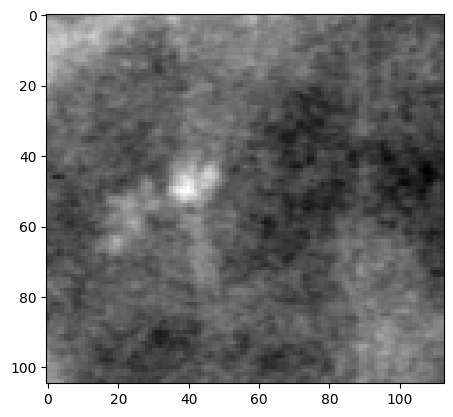

In [7]:
for file in cropped_images[0:10]:
    cropped_images_show = PIL.Image.open(file)
    gray_img= cropped_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [8]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [9]:
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.head()

1     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
2     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
11    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
12    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
15    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
Name: image_path, dtype: object

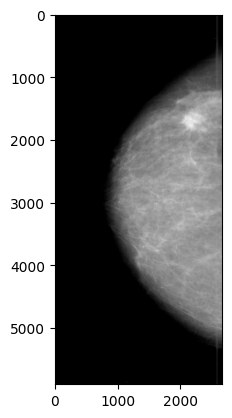

In [10]:
for file  in full_mammogram_images[0:10]:
    full_mammogram_images_show = PIL.Image.open(file)
    gray_img= full_mammogram_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [11]:
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [12]:
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_mask_images.head()

5     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
8     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
9     /kaggle/input/cbis-ddsm-breast-cancer-image-da...
14    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
20    /kaggle/input/cbis-ddsm-breast-cancer-image-da...
Name: image_path, dtype: object

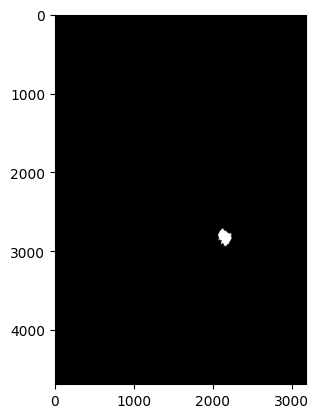

In [13]:
for file  in ROI_mask_images[0:10]:
    ROI_mask_images_show = PIL.Image.open(file)
    gray_img= ROI_mask_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

---

In [14]:
calc_case_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')

In [15]:
calc_case_df.head(5)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [16]:
mass_case_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')

In [17]:
mass_case_df.head(5)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


### Data Cleaning

In [18]:
dicom_cleaned_data = dicom_data.copy()
dicom_cleaned_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [19]:
dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True) 

In [20]:
dicom_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   file_path                                    10237 non-null  object
 1   image_path                                   10237 non-null  object
 2   BitsAllocated                                10237 non-null  int64 
 3   BitsStored                                   10237 non-null  int64 
 4   BodyPartExamined                             10237 non-null  object
 5   ConversionType                               10237 non-null  object
 6   HighBit                                      10237 non-null  int64 
 7   LargestImagePixelValue                       10237 non-null  int64 
 8   Laterality                                   9671 non-null   object
 9   Modality                                     10237 non-null  object
 10  PatientID 

In [21]:
dicom_cleaned_data.isna().sum()

file_path                                        0
image_path                                       0
BitsAllocated                                    0
BitsStored                                       0
BodyPartExamined                                 0
ConversionType                                   0
HighBit                                          0
LargestImagePixelValue                           0
Laterality                                     566
Modality                                         0
PatientID                                        0
PatientName                                      0
PatientOrientation                               0
PhotometricInterpretation                        0
PixelRepresentation                              0
SamplesPerPixel                                  0
SecondaryCaptureDeviceManufacturer               0
SecondaryCaptureDeviceManufacturerModelName      0
SeriesDescription                              566
SmallestImagePixelValue        

In [22]:
dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)

In [23]:
dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

In [24]:
dicom_cleaned_data.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [25]:
Data_cleaning_1 = calc_case_df.copy()
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc type':'calc_type'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc distribution':'calc_distribution'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'image view':'image_view'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'breast density':'breast_density'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_1['pathology'] = Data_cleaning_1['pathology'].astype('category')
Data_cleaning_1['calc_type'] = Data_cleaning_1['calc_type'].astype('category')
Data_cleaning_1['calc_distribution'] = Data_cleaning_1['calc_distribution'].astype('category')
Data_cleaning_1['abnormality_type'] = Data_cleaning_1['abnormality_type'].astype('category')
Data_cleaning_1['image_view'] = Data_cleaning_1['image_view'].astype('category')
Data_cleaning_1['left_or_right_breast'] = Data_cleaning_1['left_or_right_breast'].astype('category')
Data_cleaning_1.isna().sum()

patient_id                   0
breast_density               0
left_or_right_breast         0
image_view                   0
abnormality id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [26]:
Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_1['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_1.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [27]:
Data_cleaning_2 = mass_case_df.copy()
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass shape':'mass_shape'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass margins':'mass_margins'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'image view':'image_view'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_2['left_or_right_breast'] = Data_cleaning_2['left_or_right_breast'].astype('category')
Data_cleaning_2['image_view'] = Data_cleaning_2['image_view'].astype('category')
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].astype('category')
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].astype('category')
Data_cleaning_2['abnormality_type'] = Data_cleaning_2['abnormality_type'].astype('category')
Data_cleaning_2['pathology'] = Data_cleaning_2['pathology'].astype('category')
Data_cleaning_2.isna().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [28]:
Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

---

### Data Visualization

In [29]:
breast_imgs = glob.glob('/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [30]:
for imgname in breast_imgs[:5]:
    print(imgname)

/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1351_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y501_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x1501_y1101_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x451_y901_class0.png
/kaggle/input/breast-histopathology-images/IDC_regular_ps50_idx5/10295/0/10295_idx5_x801_y451_class0.png


In [31]:
non_cancer_imgs = []
cancer_imgs = []

for img in breast_imgs:
    if img[-5] == '0' :
        non_cancer_imgs.append(img)
    
    elif img[-5] == '1' :
        cancer_imgs.append(img)

In [32]:
non_cancer_num = len(non_cancer_imgs)  # No cancer
cancer_num = len(cancer_imgs)   # Cancer 
        
total_img_num = non_cancer_num + cancer_num
        
print('Number of Images of no cancer: {}' .format(non_cancer_num))   # images of Non cancer
print('Number of Images of cancer : {}' .format(cancer_num))   # images of cancer 
print('Total Number of Images : {}' .format(total_img_num))

Number of Images of no cancer: 198738
Number of Images of cancer : 78786
Total Number of Images : 277524


In [33]:
data_insight_1 = pd.DataFrame({'state of cancer' : ['0','1'],'Numbers of Patients' : [198738,78786]})

In [34]:
bar = px.bar(data_frame=data_insight_1, x = 'state of cancer', y='Numbers of Patients', color='state of cancer')
bar.update_layout(title_text='Number of Patients with cancer (1) and patients with no cancer (0)', title_x=0.5)
bar.show()

In [35]:
r= pd.DataFrame(dicom_cleaned_data['SeriesDescription'].value_counts())
r= r.reset_index()
r= r.rename(columns={'SeriesDescription':'SeriesDescription_counts', 'index':'SeriesDescription'})
r

,SeriesDescription_counts,count
0,cropped images,3859
1,ROI mask images,3340
2,full mammogram images,3038


In [36]:
ba_1 = px.bar(data_frame=dicom_cleaned_data, x='SeriesDescription', color='SeriesDescription',
              title='Types of images used')
ba_1.update_layout(title_text='Types of images used', title_x=0.5)
ba_1.show()

from cbis-ddsm-breast-cancer-image-dataset : This study depends on Three types of images ; `cropped images` , `ROI images` , `Full mammogram images` . from this graph we conclude that `cropped images` is the most used between them

In [37]:
f= pd.DataFrame(dicom_cleaned_data['BodyPartExamined'].value_counts())
f= f.reset_index()
f= f.rename(columns={'BodyPartExamined':'BodyPartExamined_counts', 'index':'Breast part Examined'})
f

,BodyPartExamined_counts,count
0,BREAST,9671
1,Left Breast,318
2,Right Breast,248


In [38]:
ba = px.bar(data_frame=f, x="BodyPartExamined_counts", y="count", color="BodyPartExamined_counts")
ba.update_layout(title_text='Breast Parts Examined', title_x=0.5, yaxis=dict(type='log'))
ba.show()

**The Most Part Examined is Breast "All" = left and also right**

In [39]:
data_insight_2 = pd.DataFrame({'abnormality':[Data_cleaning_1.abnormality_type[0],Data_cleaning_2.abnormality_type[0]],
                               'counts_of_abnormalties':[len(Data_cleaning_1),len(Data_cleaning_2)]})
data_insight_2

,abnormality,counts_of_abnormalties
0,calcification,1546
1,mass,1318


In [40]:
bar_2 =px.bar(data_frame=data_insight_2, x = 'abnormality', y='counts_of_abnormalties', color = 'abnormality')
bar_2.update_layout(title_text='Types of abnormalites of cancer', title_x=0.5)
bar_2.show()

from this graph: 
There are two abnormalities of breast cancer:
- Calcification abnormality
- Mass abnormality 

**Most cases are with calcification abnormalities**

In [41]:
x = Data_cleaning_1.left_or_right_breast.value_counts().RIGHT
y = Data_cleaning_1.left_or_right_breast.value_counts().LEFT
print(x,y)

728 818


In [42]:
data_insight_3 = pd.DataFrame({'left_or_right_breast':['RIGHT','LEFT'] , 'Counts':[x,y]})
data_insight_3

,left_or_right_breast,Counts
0,RIGHT,728
1,LEFT,818


In [43]:
insight_3 = px.bar(data_insight_3, y= 'Counts', x='left_or_right_breast',color = 'left_or_right_breast')
insight_3.update_layout(title_text=' clacification cancer position of the breasts ', title_x=0.5)
insight_3.show()

**For calcification cancer, most cases are usually in the left breast.**

In [44]:
z = pd.DataFrame(Data_cleaning_1['calc_type'].value_counts())
z = z.reset_index()
z= z.rename(columns={'calc_type':'calc_type_counts'})
z

,calc_type_counts,count
0,PLEOMORPHIC,664
1,AMORPHOUS,139
2,PUNCTATE,106
3,LUCENT_CENTER,93
4,VASCULAR,82
5,FINE_LINEAR_BRANCHING,77
6,COARSE,35
7,ROUND_AND_REGULAR-LUCENT_CENTER,33
8,PLEOMORPHIC-FINE_LINEAR_BRANCHING,28
9,ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE,24


**Calcification cancer has 45 types, the majority of which are PLEOMORPHIC.**

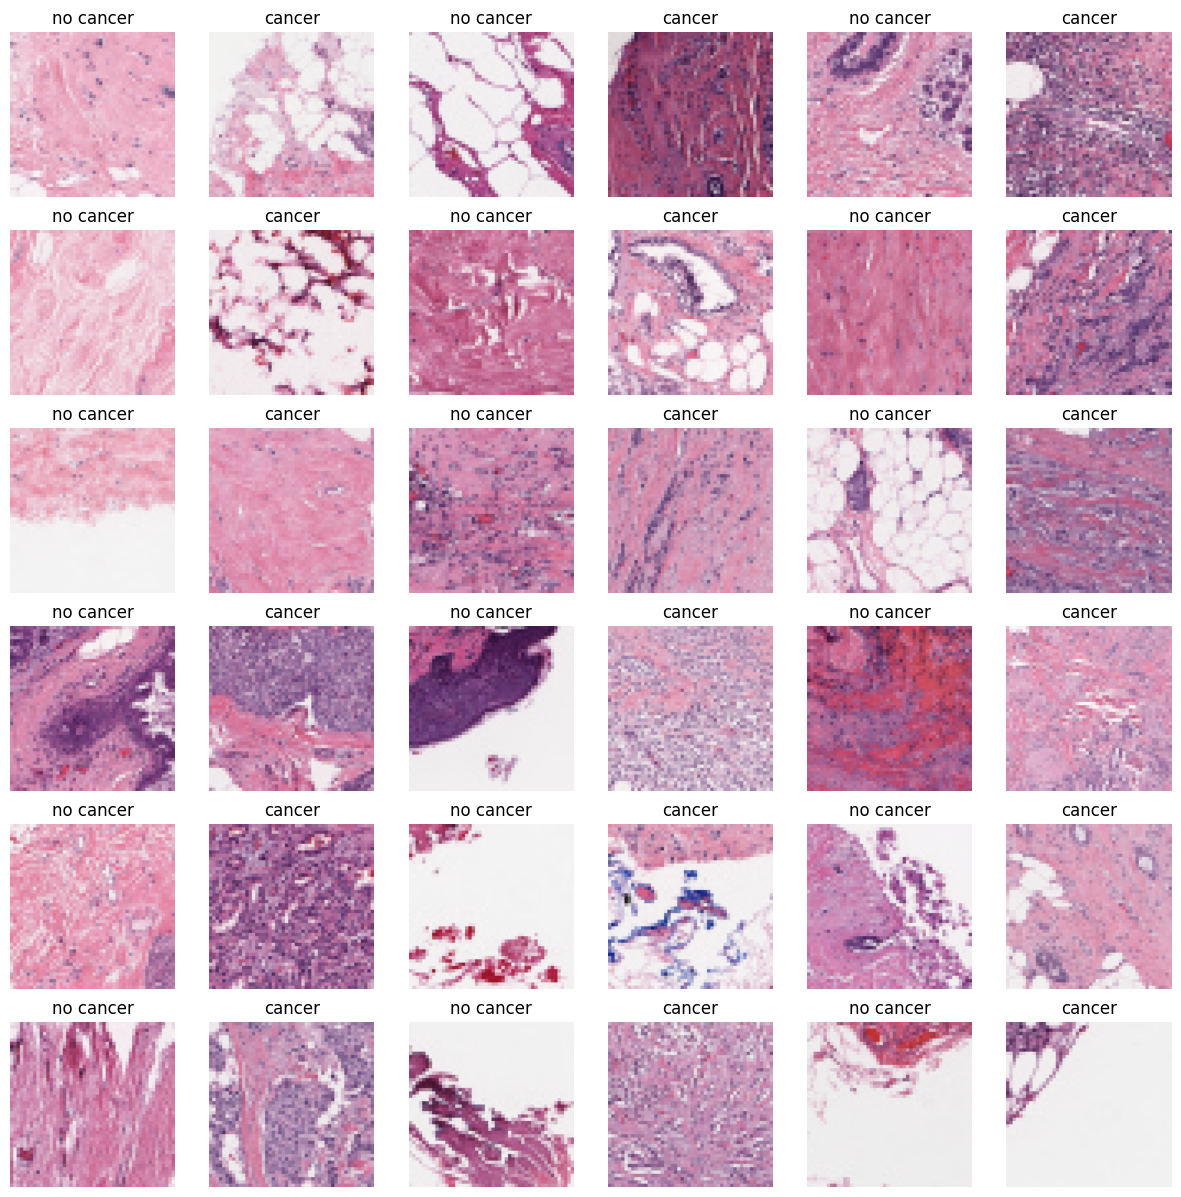

In [45]:
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(non_cancer_imgs), 18)
some_can = np.random.randint(0, len(cancer_imgs), 18)

s = 0
for num in some_non:
    
        img = image.image_utils.load_img((non_cancer_imgs[num]), target_size=(100, 100))
        img = image.image_utils.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
        
s = 1
for num in some_can:
    
        img = image.image_utils.load_img((cancer_imgs[num]), target_size=(100, 100))
        img = image.image_utils.img_to_array(img)
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('cancer')
        plt.imshow(img.astype('uint8'))
        s += 1

---
### Data Modeling

In [46]:
# Randomly sample images from two lists, 'non_cancer_imgs' and 'cancer_imgs'
some_non_img = random.sample(non_cancer_imgs, len(non_cancer_imgs))
some_can_img = random.sample(cancer_imgs, len(cancer_imgs))

# Initialize empty arrays to store image data and labels
non_img_arr = []  # Array for non-cancer images
can_img_arr = []  # Array for cancer images

# Loop through each image in the 'some_non_img' list
for img in some_non_img:
    # Read the image in color mode
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    n_img_size = cv2.resize(n_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 0 (indicating non-cancer) to the 'non_img_arr'
    non_img_arr.append([n_img_size, 0])

# Loop through each image in the 'some_can_img' list
for img in some_can_img:
    # Read the image in color mode
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    # Resize the image to a fixed size (50x50 pixels) using linear interpolation
    c_img_size = cv2.resize(c_img, (50, 50), interpolation=cv2.INTER_LINEAR)
    # Append the resized image and label 1 (indicating cancer) to the 'can_img_arr'
    can_img_arr.append([c_img_size, 1])

In [47]:
X = []  # List for image data
y = []  # List for labels

# Concatenate the arrays 'non_img_arr' and 'can_img_arr' into a single array 'breast_img_arr'
breast_img_arr = np.concatenate((non_img_arr, can_img_arr))

# Shuffle the elements in the 'breast_img_arr' array randomly
random.shuffle(breast_img_arr)

# Loop through each element (feature, label) in the shuffled 'breast_img_arr'
for feature, label in breast_img_arr:
    # Append the image data (feature) to the 'X' list
    X.append(feature)
    # Append the label to the 'y' list
    y.append(label)

# Convert the lists 'X' and 'y' into NumPy arrays
X = np.array(X)
y = np.array(y)

# Print the shape of the 'X' array
print('X shape: {}'.format(X.shape))

<__array_function__ internals>:180: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



X shape: (277524, 50, 50, 3)


In [48]:
# Split the dataset into training and testing sets, with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Define a rate (percentage) for subsampling the training data
rate = 0.5

# Calculate the number of samples to keep in the training data based on the rate
num = int(X.shape[0] * rate)

# Convert the categorical labels in 'y_train' and 'y_test' to one-hot encoded format
y_train = to_categorical(y_train, 2)  # Assuming there are 2 classes (non-cancer and cancer)
y_test = to_categorical(y_test, 2)


print('X_train shape : {}' .format(X_train.shape))
print('X_test shape : {}' .format(X_test.shape))
print('y_train shape : {}' .format(y_train.shape))
print('y_test shape : {}' .format(y_test.shape))

X_train shape : (222019, 50, 50, 3)
X_test shape : (55505, 50, 50, 3)
y_train shape : (222019, 2)
y_test shape : (55505, 2)


In [49]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create data generators for training and testing
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
test_datagen = datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

In [50]:
# Define an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=5,                  # Number of epochs with no improvement after which training will be stopped
    min_delta=1e-7,              # Minimum change in the monitored quantity to be considered an improvement
    restore_best_weights=True,   # Restore model weights from the epoch with the best value of monitored quantity
)

# Define a ReduceLROnPlateau callback
plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Monitor the validation loss
    factor=0.2,           # Factor by which the learning rate will be reduced (new_lr = lr * factor)
    patience=2,           # Number of epochs with no improvement after which learning rate will be reduced
    min_delta=1e-7,       # Minimum change in the monitored quantity to trigger a learning rate reduction
    cooldown=0,           # Number of epochs to wait before resuming normal operation after learning rate reduction
    verbose=1             # Verbosity mode (1: update messages, 0: no messages)
)

In [51]:
# Set a random seed for reproducibility
tf.random.set_seed(42)

# Create a Sequential model
model = tf.keras.Sequential([
    # Convolutional layer with 32 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(50, 50, 3)),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 2x2 pool size and default stride (2)
    tf.keras.layers.MaxPooling2D(strides=2),
    
    # Convolutional layer with 64 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    # Convolutional layer with 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    # Convolutional layer with 128 filters, a 3x3 kernel, 'same' padding, and ReLU activation
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    # MaxPooling layer with a 3x3 pool size and stride of 2
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),
    
    # Flatten the output to prepare for fully connected layers
    tf.keras.layers.Flatten(),
    
    # Fully connected layer with 128 units and ReLU activation
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    # Output layer with 2 units (binary classification) and softmax activation
    tf.keras.layers.Dense(2, activation='softmax')
])

# Display a summary of the model architecture
model.summary()

# Compile the model with Adam optimizer, binary cross-entropy loss, and accuracy metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 25, 25, 64)       256       
 hNormalization)                                                 
                                                        

In [52]:
history = model.fit(X_train,
                    y_train,
                    validation_data = (X_test, y_test),
                    epochs = 25,
                    batch_size = 75,
                    callbacks=[early_stopping, plateau])

Epoch 1/25
2961/2961 [==============================] - 33s 9ms/step - loss: 0.1302 - accuracy: 0.9565 - val_loss: 0.1545 - val_accuracy: 0.9547 - lr: 0.0010
Epoch 2/25
2961/2961 [==============================] - 25s 8ms/step - loss: 0.1174 - accuracy: 0.9592 - val_loss: 0.1156 - val_accuracy: 0.9590 - lr: 0.0010
Epoch 3/25
2961/2961 [==============================] - 25s 8ms/step - loss: 0.1124 - accuracy: 0.9608 - val_loss: 0.1350 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 4/25
2956/2961 [============================>.] - ETA: 0s - loss: 0.1088 - accuracy: 0.9618
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2961/2961 [==============================] - 25s 9ms/step - loss: 0.1088 - accuracy: 0.9618 - val_loss: 0.1448 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 5/25
2961/2961 [==============================] - 25s 8ms/step - loss: 0.0996 - accuracy: 0.9647 - val_loss: 0.1096 - val_accuracy: 0.9603 - lr: 2.0000e-04
Epoch 6/25
2961/2961 [====================

In [53]:
model.evaluate(X_test,y_test)

1735/1735 [==============================] - 5s 3ms/step - loss: 0.1074 - accuracy: 0.9644


[0.10736459493637085, 0.9643995761871338]

1735/1735 [==============================] - 4s 2ms/step


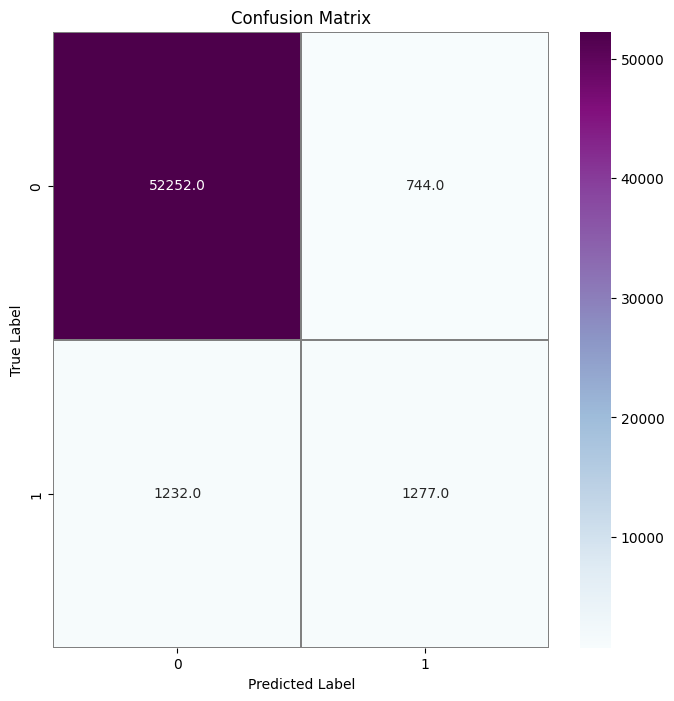

In [54]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="BuPu",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

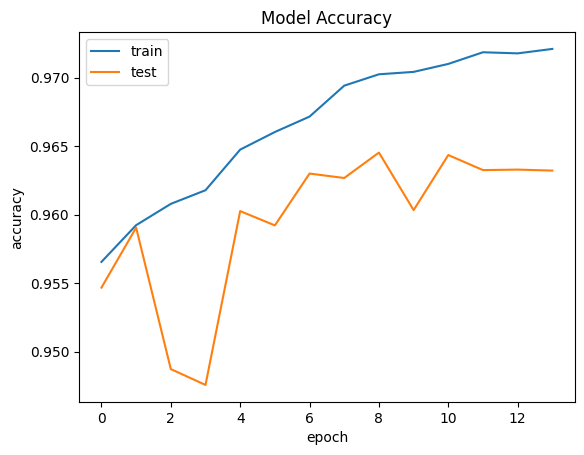

In [55]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

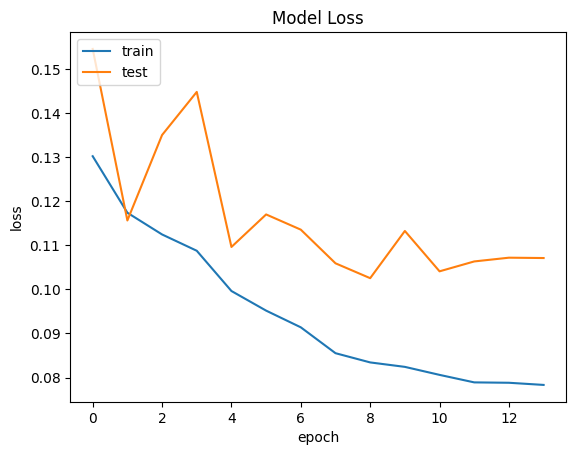

In [56]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [57]:
prediction = model.predict(X_test)
prediction

1735/1735 [==============================] - 3s 2ms/step


array([[1.0000000e+00, 1.9870817e-10],
       [9.9998462e-01, 1.5403417e-05],
       [9.9992275e-01, 7.7196732e-05],
       ...,
       [9.5727652e-31, 1.0000000e+00],
       [9.5248296e-08, 9.9999988e-01],
       [1.7645372e-26, 1.0000000e+00]], dtype=float32)

### Testing the Model

1/1 [==============================] - 0s 93ms/step
Predicted Diagnosis: Non-Cancerous
Calcification Type: No Calcification
True Diagnosis: Non-Cancerous


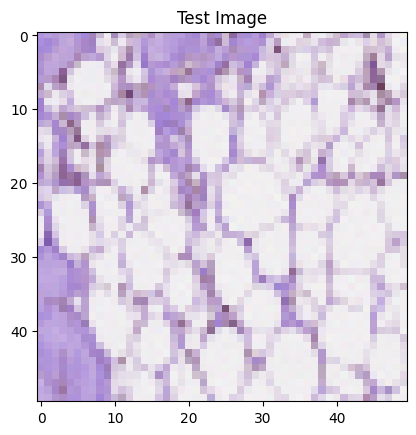

In [58]:
# Define a mapping of class indices to human-readable labels
class_labels = {
    0: 'Non-Cancerous',
    1: 'Cancerous',
}

# Define a mapping of calcification types
calcification_types = {
    0: 'No Calcification',
    1: 'PLEOMORPHIC',
    2: 'AMORPHOUS',
    3: 'PUNCTATE',
    4: 'LUCENT_CENTER',
    5: 'VASCULAR',
    6: 'FINE_LINEAR_BRANCHING',
    7: 'COARSE',
    8: 'ROUND_AND_REGULAR-LUCENT_CENTER',
    9: 'PLEOMORPHIC-FINE_LINEAR_BRANCHING',
    10: 'ROUND_AND_REGULAR-LUCENT_CENTER-PUNCTATE',
    11: 'ROUND_AND_REGULAR-EGGSHELL',
    12: 'PUNCTATE-PLEOMORPHIC',
    13: 'DYSTROPHIC',
    14: 'LUCENT_CENTERED',
    15: 'ROUND_AND_REGULAR-LUCENT_CENTER-DYSTROPHIC',
    16: 'ROUND_AND_REGULAR',
    17: 'ROUND_AND_REGULAR-LUCENT_CENTERED',
    18: 'AMORPHOUS-PLEOMORPHIC',
    19: 'LARGE_RODLIKE-ROUND_AND_REGULAR',
    20: 'PUNCTATE-AMORPHOUS',
    21: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTER',
    22: 'VASCULAR-COARSE-LUCENT_CENTERED',
    23: 'LUCENT_CENTER-PUNCTATE',
    24: 'ROUND_AND_REGULAR-PLEOMORPHIC',
    25: 'EGGSHELL',
    26: 'PUNCTATE-FINE_LINEAR_BRANCHING',
    27: 'VASCULAR-COARSE',
    28: 'ROUND_AND_REGULAR-PUNCTATE',
    29: 'SKIN-PUNCTATE-ROUND_AND_REGULAR',
    30: 'SKIN-PUNCTATE',
    31: 'COARSE-ROUND_AND_REGULAR-LUCENT_CENTERED',
    32: 'PUNCTATE-ROUND_AND_REGULAR',
    33: 'LARGE_RODLIKE',
    34: 'AMORPHOUS-ROUND_AND_REGULAR',
    35: 'PUNCTATE-LUCENT_CENTER',
    36: 'SKIN',
    37: 'VASCULAR-COARSE-LUCENT_CENTER-ROUND_AND_REGULA',
    38: 'COARSE-PLEOMORPHIC',
    39: 'ROUND_AND_REGULAR-PUNCTATE-AMORPHOUS',
    40: 'COARSE-LUCENT_CENTER',
    41: 'MILK_OF_CALCIUM',
    42: 'COARSE-ROUND_AND_REGULAR',
    43: 'SKIN-COARSE-ROUND_AND_REGULAR',
    44: 'ROUND_AND_REGULAR-AMORPHOUS',
    45: 'PLEOMORPHIC-PLEOMORPHIC'
}

# Define a function for plotting an image from an array
def img_plot(arr, index=0):
    # Set the title for the plot
    plt.title('Test Image')
    
    # Display the image at the specified index in the array
    plt.imshow(arr[index])

# Set the index value to 90
index = 90

# Plot an image from the X_test array using the img_plot function
img_plot(X_test, index)

# Extract a single image from X_test based on the specified index
input = X_test[index:index+1]

# Make a prediction using the CNN model and get the class with the highest probability
predicted_class_index = model.predict(input)[0].argmax()

# Get the true label from the y_test array
true_class_index = y_test[index].argmax()

# Get the predicted and true labels
predicted_label = class_labels[predicted_class_index]
true_label = class_labels[true_class_index]

# Get the calcification type based on the predicted class index (modify as needed)
calcification_type = calcification_types[predicted_class_index]

# Print the prediction result with calcification type
print('Predicted Diagnosis:', predicted_label)
print('Calcification Type:', calcification_type)
print('True Diagnosis:', true_label)

#### Saving the model

In [59]:
model.save('CNN_model.h5')

### Testing the Model on MINI DDSM Dataset

1/1 [==============================] - 0s 119ms/step


TypeError: Image data of dtype <U105 cannot be converted to float

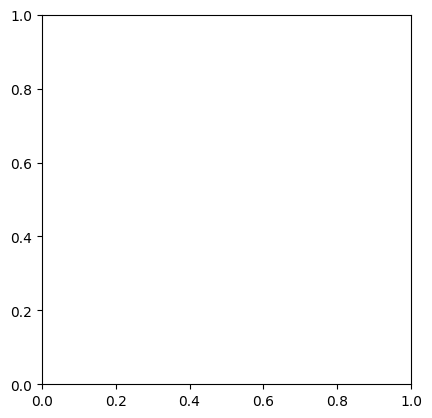

In [60]:
# Directory containing the images
imgs_dir = glob.glob('/kaggle/input/miniddsm2/MINI-DDSM-Complete-JPEG-8/Benign/**/*.jpeg', recursive=True)

# Example image path
image_path = '/kaggle/input/miniddsm2/MINI-DDSM-Complete-JPEG-8/Benign/0029/C_0029_1.LEFT_CC.jpg'

# Define a function to load and preprocess an image
def load_and_preprocess_image(image_path, target_size=(50, 50)):
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB format
        img = cv2.resize(img, target_size)  # Resize to your target size
        img_array = img / 255.0  # Normalize pixel values

        return img_array
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

# Load and preprocess the example image
img_array = load_and_preprocess_image(image_path)

if img_array is not None:
    # Create a batch for prediction (even if it's a single image)
    img_batch = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_batch)

    # Assuming your model predicts binary probabilities, you can get the probability for "Cancer" class
    cancer_probability = predictions[0][0]  # Assuming "Cancer" is the first class

    # Get the predicted class label
    predicted_class = "Cancer" if cancer_probability >= 0.5 else "Normal"

    # Plot the image and display the predicted class and probability
    plt.imshow(img)
    plt.title(f'Predicted Class: {predicted_class}\nProbability of Cancer: {cancer_probability:.4f}')
    plt.axis('off')
    plt.show()
else:
    print("Image loading and preprocessing failed.")